In [21]:
import torchvision.transforms as transforms
import os
import json
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageDraw, Image, ImageFont
from IPython.display import clear_output, HTML, display
from IPython.display import clear_output, HTML, display

import sys
sys.path.append('..')
from datasets.dataset_utils import listdir_nohidden, normalize_trajectory, random_rotation_augment

In [45]:
resize_transform_rgb = transforms.Compose([transforms.Resize(64), transforms.ToTensor()])
resize_transform_depth = transforms.Compose([transforms.Resize(64)])

episode_path = '../data/replica_all/train/01'
episode_path = '../data/clevr/train/01'
with open(os.path.join(episode_path, 'cameras.json'), 'r') as f:
    cameras = json.load(f)

Rt = []
K = []
rgb = []
depth = []
for idx, i in enumerate(list(range(8))):
    Rt.append(torch.Tensor(cameras[i]['Rt']))
    K.append(torch.Tensor(cameras[i]['K']))

    _rgb = os.path.join(episode_path, str(i).zfill(3) + '_rgb.png')
    _rgb = resize_transform_rgb(Image.open(_rgb))
    rgb.append(_rgb[:3, :, :])

    _depth = os.path.join(episode_path, str(i).zfill(3) + '_depth.tiff')
    # We dont want to normalize depth values
    _depth = resize_transform_depth(Image.open(_depth))
    depth.append(torch.from_numpy(np.array(_depth)).unsqueeze(0))
    
rgb = torch.stack(rgb)
depth = torch.stack(depth).float()
K = torch.stack(K)
Rt = torch.stack(Rt)
Rt = Rt.inverse()
print(Rt[:4])

Rt[:, [1, 2], 3] = Rt[:, [2,1], 3]
print(Rt[:4])

P = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]]) #Rx rotation by 90 degrees
Rt[:, :3, :3] = Rt[:, :3, :3] @ P
print(Rt[:4])

Rt = Rt.unsqueeze(0)  # add batch dimension
Rt = normalize_trajectory(Rt, center='first', normalize_rotation=True)
Rt = Rt[0]  # remove batch dimension

print(Rt)

tensor([[[ 6.3011e-01,  3.9557e-01, -6.6819e-01,  7.6224e+00],
         [ 7.7650e-01, -3.2100e-01,  5.4222e-01, -6.1854e+00],
         [ 4.2864e-09, -8.6051e-01, -5.0943e-01,  5.8113e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 6.3011e-01,  3.9557e-01, -6.6819e-01,  7.6224e+00],
         [ 7.7650e-01, -3.2100e-01,  5.4222e-01, -6.1854e+00],
         [ 4.2864e-09, -8.6051e-01, -5.0943e-01,  5.8113e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 1.5744e-01,  5.0307e-01, -8.4978e-01,  9.6939e+00],
         [ 9.8753e-01, -8.0206e-02,  1.3548e-01, -1.5455e+00],
         [ 4.7925e-08, -8.6051e-01, -5.0943e-01,  5.8113e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-3.5741e-01,  4.7578e-01, -8.0367e-01,  9.1680e+00],
         [ 9.3395e-01,  1.8208e-01, -3.0756e-01,  3.5085e+00],
         [ 1.0574e-07, -8.6051e-01, -5.0943e-01,  5.8113e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, 

tensor([ 7.6224,  7.6224,  9.6939,  9.1680,  6.1854,  1.5455, -3.5085, -7.6224]) tensor([5.8113, 5.8113, 5.8113, 5.8113, 5.8113, 5.8113, 5.8113, 5.8113]) tensor([-6.1854, -6.1854, -1.5455,  3.5085,  7.6224,  9.6939,  9.1680,  6.1854])


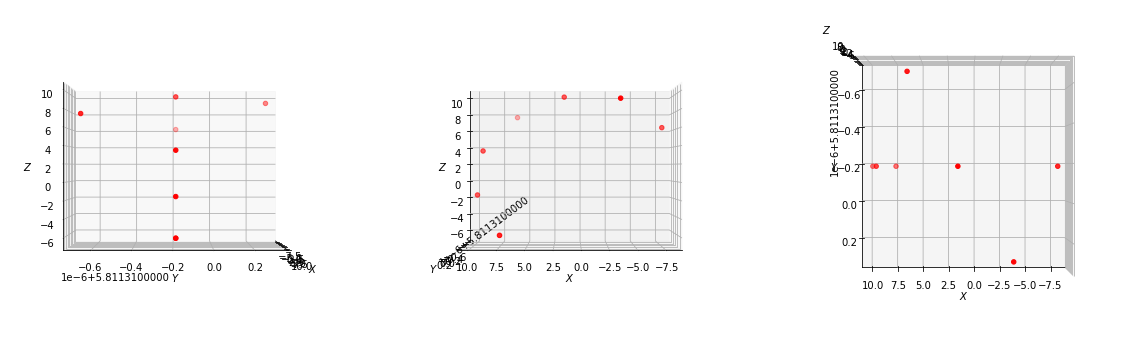

In [44]:
X, Y, Z = Rt[:, 0, 3], Rt[:, 1, 3], Rt[:, 2, 3]
print(X, Y, Z)

# Plot X,Y,Z
fig = plt.figure(figsize = (20, 10))
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter3D(X, Y, Z, c='red')
ax1.set_xlabel('$X$')
ax1.set_ylabel('$Y$')
ax1.set_zlabel('$Z$')
ax1.view_init(0, 0)

ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter3D(X, Y, Z, c='red')
ax2.set_xlabel('$X$')
ax2.set_ylabel('$Y$')
ax2.set_zlabel('$Z$')
ax2.view_init(0, 90)

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter3D(X, Y, Z, c='red')
ax3.set_xlabel('$X$')
ax3.set_ylabel('$Y$')
ax3.set_zlabel('$Z$')
ax3.view_init(90, 90)

plt.show()